<a href="https://colab.research.google.com/github/DarwinFer/ProblemaInversoBurger1-1D_E4/blob/main/ProblemaInversoBurger1_1D_E4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Problema inverso (Recostrución de la condición inicial)

Presentamos la implentación de un problema inverso asociado a la ecuación de Burgers viscosa en 1 Dimensión.

El procedimiento es el siguiente:
1.   Genereamos datos $\mathcal{D}$  a partir de la simulación en el problema directo.
2.   Entrenamos una red reuronal que aprende la solución  y asi se genrera la aproximación en la condicion inicial.




[FWD] Epoch   500 | Loss: 3.430e-02 | phys=5.44e-02 bc=1.82e-03 ic=4.36e-02
[FWD] Epoch  1000 | Loss: 2.117e-02 | phys=3.74e-02 bc=4.21e-04 ic=2.46e-02
[FWD] Epoch  1500 | Loss: 1.190e-02 | phys=1.47e-02 bc=1.32e-04 ic=1.86e-02
[FWD] Epoch  2000 | Loss: 1.062e-02 | phys=1.18e-02 bc=6.79e-05 ic=1.76e-02
[FWD] Epoch  2500 | Loss: 9.652e-03 | phys=1.14e-02 bc=4.01e-05 ic=1.56e-02
[FWD] Epoch  3000 | Loss: 8.585e-03 | phys=1.08e-02 bc=3.40e-05 ic=1.33e-02
[FWD] Epoch  3500 | Loss: 7.219e-03 | phys=9.80e-03 bc=3.01e-05 ic=1.07e-02
[FWD] Epoch  4000 | Loss: 5.584e-03 | phys=8.35e-03 bc=2.31e-05 ic=7.68e-03
[FWD] Epoch  4500 | Loss: 3.949e-03 | phys=6.46e-03 bc=7.58e-05 ic=4.97e-03
[FWD] Epoch  5000 | Loss: 2.562e-03 | phys=4.45e-03 bc=1.94e-05 ic=3.05e-03


/tmp/ipython-input-280240133.py:152: UserWarning: Glyph 119967 (\N{MATHEMATICAL SCRIPT CAPITAL D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119967 (\N{MATHEMATICAL SCRIPT CAPITAL D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


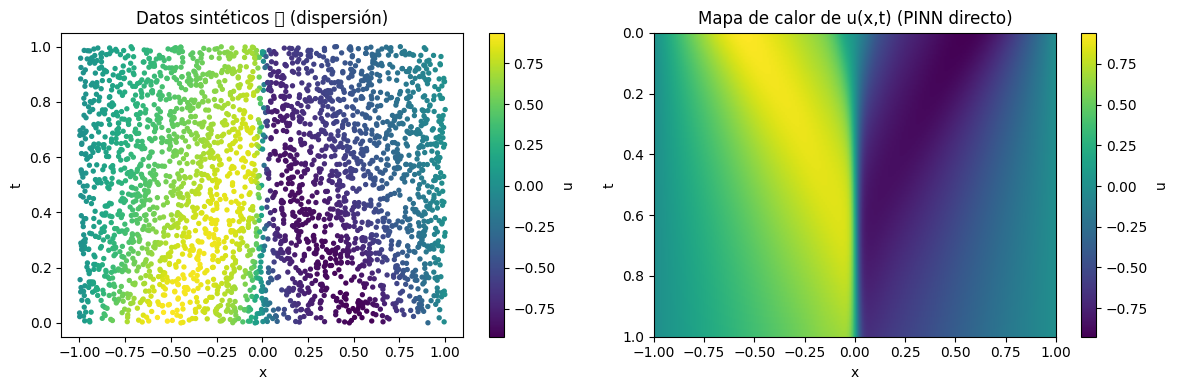

In [ ]:
# ============================================================
# BLOQUE 1: PROBLEMA DIRECTO (PINN) -> GENERACIÓN DE DATOS 𝒟 Y PLOTS
# ============================================================

# (1) Importaciones, semilla y dispositivo
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# (2) Parámetros del problema de Burgers
nu = 0.01  # viscosidad
x_min, x_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0

# (3) Definición de la arquitectura dada (2 entradas -> [50,Tanh]x2 -> 1 salida)
class BurgersPINN(nn.Module):
    def __init__(self):
        super(BurgersPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, t):
        # NOTA: concatenamos x y t en el canal de características
        return self.net(torch.cat((x, t), dim=1))

# (4) Condición inicial “verdad” para generar datos sintéticos (NO se usará en el inverso)
def u0_star(x):
    # u0*(x) = -sin(pi x)
    return -torch.sin(np.pi * x)

# (5) Mallas de entrenamiento del problema directo
#     * Interior: para residuo de la EDP
#     * Frontera: u(-1,t)=u(1,t)=0
#     * Inicial: u(x,0)=u0*(x)
N_f = 15000  # puntos de colación (física)
N_b = 400    # puntos de frontera
N_i = 2000   # puntos de condición inicial

# Muestreo uniforme en el dominio (interior) para residuo físico
x_f = (x_min + (x_max - x_min) * torch.rand(N_f, 1, device=device)).requires_grad_(True)  # interior x
t_f = (t_min + (t_max - t_min) * torch.rand(N_f, 1, device=device)).requires_grad_(True)  # interior t

# Frontera: x=-1 y x=1 para t en [0,1]
t_b = torch.linspace(t_min, t_max, N_b, device=device).reshape(-1, 1)
x_bL = -torch.ones_like(t_b, device=device)
x_bR =  torch.ones_like(t_b, device=device)
u_bL = torch.zeros_like(t_b, device=device)  # condición de Dirichlet izquierda
u_bR = torch.zeros_like(t_b, device=device)  # condición de Dirichlet derecha

# Inicial: t=0, x en [-1,1]
x_i = torch.linspace(x_min, x_max, N_i, device=device).reshape(-1, 1)
t_i = torch.zeros_like(x_i, device=device)
u_i = u0_star(x_i)  # valores exactos en t=0 para entrenar el directo

# (6) Instanciar PINN del problema directo
model_fwd = BurgersPINN().to(device)

# (7) Funciones auxiliares de derivación por autograd
def grads(u, x):
    # ∂u/∂x
    return torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]

def pde_residual(model, x, t, nu):
    # Calcula R = u_t + u u_x - nu u_xx
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    R = u_t + u * u_x - nu * u_xx
    return R

# (8) Función de pérdida del problema directo
#     L = L_phys + L_bc + L_ic (todas en MSE)
w_phys, w_bc, w_ic = 0.3, 0.3, 0.4

def loss_forward(model):
    # término físico (residuo de la EDP)
    R = pde_residual(model, x_f, t_f, nu)
    L_phys = torch.mean(R**2)

    # término de frontera
    uL = model(x_bL, t_b)
    uR = model(x_bR, t_b)
    L_bc = torch.mean((uL - u_bL)**2) + torch.mean((uR - u_bR)**2)

    # término de condición inicial
    u_init = model(x_i, t_i)
    L_ic = torch.mean((u_init - u_i)**2)

    return w_phys*L_phys + w_bc*L_bc + w_ic*L_ic, {'phys':L_phys.item(), 'bc':L_bc.item(), 'ic':L_ic.item()}

# (9) Entrenamiento del problema directo (genera el “simulador” para producir 𝒟)
optimizer = optim.Adam(model_fwd.parameters(), lr=1e-3)
epochs_fwd = 5000  # puede aumentarse en GPU

for epoch in range(1, epochs_fwd+1):
    optimizer.zero_grad()
    L, parts = loss_forward(model_fwd)
    L.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"[FWD] Epoch {epoch:5d} | Loss: {L.item():.3e} | phys={parts['phys']:.2e} bc={parts['bc']:.2e} ic={parts['ic']:.2e}")

# (10) Generación de datos sintéticos 𝒟 = {(x_i,t_i,u_i)} usando el modelo directo entrenado
N_d = 3000  # tamaño del dataset de mediciones
x_d = (x_min + (x_max - x_min) * torch.rand(N_d, 1, device=device))
t_d = (t_min + (t_max - t_min) * torch.rand(N_d, 1, device=device))
with torch.no_grad():
    u_d = model_fwd(x_d, t_d)

# Convertimos a CPU para plotting
x_d_cpu = x_d.detach().cpu().numpy().ravel()
t_d_cpu = t_d.detach().cpu().numpy().ravel()
u_d_cpu = u_d.detach().cpu().numpy().ravel()

# (11) Plot de los datos generados (dispersión y mapa de calor en rejilla)
#      Este plot visualiza 𝒟 y servirá como referencia para el inverso
fig = plt.figure(figsize=(12,4))

# Dispersión de puntos (x,t) coloreados por u
ax1 = fig.add_subplot(1,2,1)
sc = ax1.scatter(x_d_cpu, t_d_cpu, c=u_d_cpu, s=8)
ax1.set_xlabel('x'); ax1.set_ylabel('t'); ax1.set_title('Datos sintéticos 𝒟 (dispersión)')
plt.colorbar(sc, ax=ax1, label='u')

# Mapa de calor en malla regular para mejor lectura
nx, nt = 200, 200
xg = np.linspace(x_min, x_max, nx).reshape(-1,1)
tg = np.linspace(t_min, t_max, nt).reshape(-1,1)
Xg, Tg = np.meshgrid(xg.ravel(), tg.ravel())
with torch.no_grad():
    ug = model_fwd(torch.tensor(Xg.reshape(-1,1), dtype=torch.float32, device=device),
                   torch.tensor(Tg.reshape(-1,1), dtype=torch.float32, device=device))
Ug = ug.detach().cpu().numpy().reshape(nt, nx)

ax2 = fig.add_subplot(1,2,2)
im = ax2.imshow(Ug, extent=[x_min,x_max,t_max,t_min], aspect='auto')
ax2.set_xlabel('x'); ax2.set_ylabel('t'); ax2.set_title('Mapa de calor de u(x,t) (PINN directo)')
plt.colorbar(im, ax=ax2, label='u')
plt.tight_layout()
plt.show()

# Guardamos 𝒟 para el bloque inverso
D_data = {
    'x': x_d.detach(),
    't': t_d.detach(),
    'u': u_d.detach()
}


[INV] Epoch   500 | Loss: 9.180e-02 | data=6.24e-02 phys=1.56e-02 bc=1.58e-03 reg=1.22e+00
[INV] Epoch  1000 | Loss: 7.073e-02 | data=4.05e-02 phys=1.16e-02 bc=1.42e-03 reg=1.73e+00
[INV] Epoch  1500 | Loss: 5.409e-02 | data=2.27e-02 phys=7.49e-03 bc=1.35e-03 reg=2.26e+00
[INV] Epoch  2000 | Loss: 4.498e-02 | data=1.39e-02 phys=4.63e-03 bc=1.27e-03 reg=2.52e+00
[INV] Epoch  2500 | Loss: 4.121e-02 | data=1.01e-02 phys=3.61e-03 bc=1.35e-03 reg=2.62e+00
[INV] Epoch  3000 | Loss: 3.949e-02 | data=8.28e-03 phys=3.12e-03 bc=1.35e-03 reg=2.67e+00
[INV] Epoch  3500 | Loss: 3.785e-02 | data=7.26e-03 phys=2.26e-03 bc=1.33e-03 reg=2.70e+00
[INV] Epoch  4000 | Loss: 3.718e-02 | data=7.00e-03 phys=2.08e-03 bc=1.07e-03 reg=2.70e+00
[INV] Epoch  4500 | Loss: 3.717e-02 | data=6.11e-03 phys=1.79e-03 bc=2.15e-03 reg=2.71e+00
[INV] Epoch  5000 | Loss: 3.617e-02 | data=6.25e-03 phys=1.62e-03 bc=1.23e-03 reg=2.71e+00
[INV] Epoch  5500 | Loss: 3.580e-02 | data=5.99e-03 phys=1.49e-03 bc=1.27e-03 reg=2.71e+00

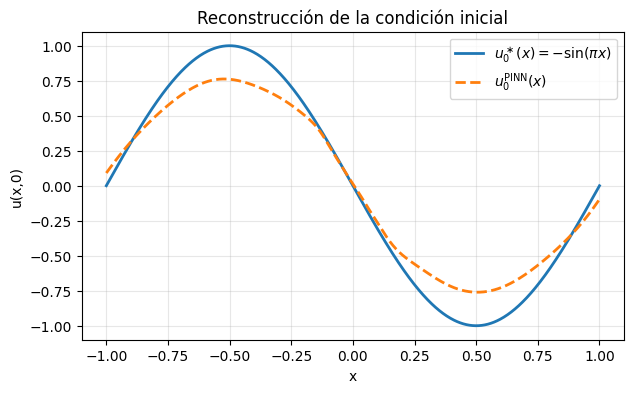


Tabla de error relativo en norma L2 (IC):


/tmp/ipython-input-3591994940.py:95: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  num = np.sqrt(np.trapz((u0_rec - u0_exact)**2, x_eval_np))
/tmp/ipython-input-3591994940.py:96: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  den = np.sqrt(np.trapz((u0_exact)**2, x_eval_np))


,Métrica,Valor
0,$\varepsilon_{\mathrm{IC}}$,0.220081



|u(-1,0)|_max ≈ 9.08e-02   |u(1,0)|_max ≈ 9.65e-02


In [ ]:
# ============================================================
# BLOQUE 2: PROBLEMA INVERSO (PINN) -> RECONSTRUCCIÓN DE u0(x)
# ============================================================

# (1) Cargamos 𝒟 desde el bloque anterior (x,t,u)
x_d = D_data['x'].to(device)
t_d = D_data['t'].to(device)
u_d = D_data['u'].to(device)

# (2) Definimos nuevo modelo PINN (arquitectura similar) para el problema inverso
model_inv = BurgersPINN().to(device)

# (3) Puntos de colación para el término físico y de frontera (no usan u0*)
N_f_inv = 15000
x_f_inv = (x_min + (x_max - x_min) * torch.rand(N_f_inv, 1, device=device)).requires_grad_(True)
t_f_inv = (t_min + (t_max - t_min) * torch.rand(N_f_inv, 1, device=device)).requires_grad_(True)

N_b_inv = 400
t_b_inv = torch.linspace(t_min, t_max, N_b_inv, device=device).reshape(-1, 1)
x_bL_inv = -torch.ones_like(t_b_inv, device=device)
x_bR_inv =  torch.ones_like(t_b_inv, device=device)
u_bL_inv = torch.zeros_like(t_b_inv, device=device)
u_bR_inv = torch.zeros_like(t_b_inv, device=device)

# (4) Puntos en t=0 para la regularización H1 (no es la IC exacta; solo para ∥∂x u(x,0)∥^2)
N0 = 1024
x0_reg = torch.linspace(x_min, x_max, N0, device=device).reshape(-1,1).requires_grad_(True)
t0_reg = torch.zeros_like(x0_reg, device=device).requires_grad_(True)

# (5) Función de pérdida del inverso según el fragmento:
#     L = λ_d L_data + λ_f L_phys + λ_b L_bc + λ_reg L_reg
lambda_d   = 1
lambda_f   = 1
lambda_b   = 1
lambda_reg = 1e-2  # regularización H1 suave; puede ajustarse

def loss_inverse(model):
    # --- Término de datos: ajuste a 𝒟 ---
    u_pred_d = model(x_d, t_d)
    L_data = torch.mean((u_pred_d - u_d)**2)

    # --- Término físico: residuo de la EDP ---
    R = pde_residual(model, x_f_inv, t_f_inv, nu)
    L_phys = torch.mean(R**2)

    # --- Término de frontera: u(-1,t)=u(1,t)=0 ---
    uL = model(x_bL_inv, t_b_inv)
    uR = model(x_bR_inv, t_b_inv)
    L_bc = torch.mean((uL - u_bL_inv)**2) + torch.mean((uR - u_bR_inv)**2)

    # --- Término de regularización H1 en t=0: ∑ |∂x u(x,0)|^2 ---
    u0 = model(x0_reg, t0_reg)            # u(x,0)
    u0_x = torch.autograd.grad(u0, x0_reg, torch.ones_like(u0), create_graph=True)[0]
    L_reg = torch.mean(u0_x**2)

    # --- Combinación ponderada ---
    L_total = lambda_d*L_data + lambda_f*L_phys + lambda_b*L_bc + lambda_reg*L_reg
    parts = {'data':L_data.item(), 'phys':L_phys.item(), 'bc':L_bc.item(), 'reg':L_reg.item()}
    return L_total, parts

# (6) Entrenamiento del problema inverso
optimizer_inv = optim.Adam(model_inv.parameters(), lr=1e-3)
epochs_inv = 6000  # puede ajustarse

for epoch in range(1, epochs_inv+1):
    optimizer_inv.zero_grad()
    L, parts = loss_inverse(model_inv)
    L.backward()
    optimizer_inv.step()
    if epoch % 500 == 0:
        print(f"[INV] Epoch {epoch:5d} | Loss: {L.item():.3e} | data={parts['data']:.2e} phys={parts['phys']:.2e} bc={parts['bc']:.2e} reg={parts['reg']:.2e}")

# (7) Extracción de la condición inicial reconstruida u0^{PINN}(x) = u(x,0; θ*)
nx_eval = 801
x_eval = torch.linspace(x_min, x_max, nx_eval, device=device).reshape(-1,1)
t0_eval = torch.zeros_like(x_eval, device=device)
with torch.no_grad():
    u0_rec = model_inv(x_eval, t0_eval).detach().cpu().numpy().ravel()

# (8) Curva exacta vs reconstruida y cumplimiento de frontera en t=0
x_eval_np = x_eval.detach().cpu().numpy().ravel()
u0_exact = (-np.sin(np.pi * x_eval_np))

plt.figure(figsize=(7,4))
plt.plot(x_eval_np, u0_exact, label=r'$u_0^\ast(x)=-\sin(\pi x)$', linewidth=2)
plt.plot(x_eval_np, u0_rec, '--', label=r'$u_0^{\mathrm{PINN}}(x)$', linewidth=2)
plt.xlabel('x'); plt.ylabel('u(x,0)'); plt.title('Reconstrucción de la condición inicial')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# (9) Cálculo del error relativo en norma L2 sobre [-1,1]
#     ε_IC = ||u0_PINN - u0*||_L2 / ||u0*||_L2  (cuadratura trapezoidal en la malla uniforme)
dx = (x_max - x_min) / (nx_eval - 1)
num = np.sqrt(np.trapz((u0_rec - u0_exact)**2, x_eval_np))
den = np.sqrt(np.trapz((u0_exact)**2, x_eval_np))
eps_IC = num / (den + 1e-15)

# (10) Tabla de error relativo (como en el texto) y muestra de parámetros clave
df_err = pd.DataFrame({
    'Métrica': [r'$\varepsilon_{\mathrm{IC}}$'],
    'Valor':   [eps_IC]
})
print("\nTabla de error relativo en norma L2 (IC):")
display(df_err)

# (11) (Opcional) Verificación del acoplamiento a frontera en t=0 (debe estar cercano a 0)
with torch.no_grad():
    bc_left  = model_inv(torch.full_like(t0_eval, x_min), t0_eval).abs().max().item()
    bc_right = model_inv(torch.full_like(t0_eval, x_max), t0_eval).abs().max().item()
print(f"\n|u(-1,0)|_max ≈ {bc_left:.2e}   |u(1,0)|_max ≈ {bc_right:.2e}")

# ------------------------------------------------------------
# COMENTARIOS CLAVE (señalados en el código con comentarios):
#  - BLOQUE 1 entrena una PINN con IC conocida para aproximar u(x,t) y
#    luego usa ese modelo para generar el dataset sintético 𝒟.
#  - BLOQUE 2 usa 𝒟 para resolver el problema inverso, minimizando
#    L = λ_d L_data + λ_f L_phys + λ_b L_bc + λ_reg L_reg, donde
#      * L_data: ajuste a datos,
#      * L_phys: residuo de Burgers,
#      * L_bc: condiciones de frontera homogéneas,
#      * L_reg: regularización H1 en t=0 (control de ∂x u).
#  - Finalmente se grafica u0* vs u0^{PINN} y se reporta ε_IC.
# ------------------------------------------------------------


##Configuración para estudiar la precisión al elevar el número de  datos observados.

Entrenando modelo directo...
[FWD] Epoch   500 | Loss: 3.430e-02
[FWD] Epoch  1000 | Loss: 2.117e-02
[FWD] Epoch  1500 | Loss: 1.190e-02
[FWD] Epoch  2000 | Loss: 1.062e-02
[FWD] Epoch  2500 | Loss: 9.652e-03
[FWD] Epoch  3000 | Loss: 8.585e-03
[FWD] Epoch  3500 | Loss: 7.219e-03
[FWD] Epoch  4000 | Loss: 5.584e-03
[FWD] Epoch  4500 | Loss: 3.949e-03
[FWD] Epoch  5000 | Loss: 2.562e-03


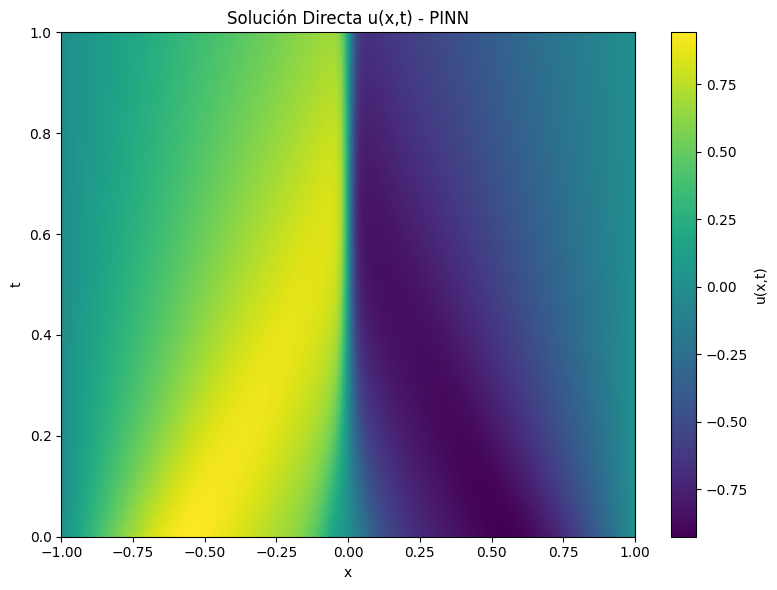


PROCESANDO DATASET CON N_d = 500

Entrenando modelo inverso para N_d=500...
[INV] Epoch  1000 | Loss: 6.711e-02
[INV] Epoch  2000 | Loss: 4.891e-02
[INV] Epoch  3000 | Loss: 4.172e-02
[INV] Epoch  4000 | Loss: 3.830e-02
[INV] Epoch  5000 | Loss: 3.641e-02
[INV] Epoch  6000 | Loss: 3.591e-02


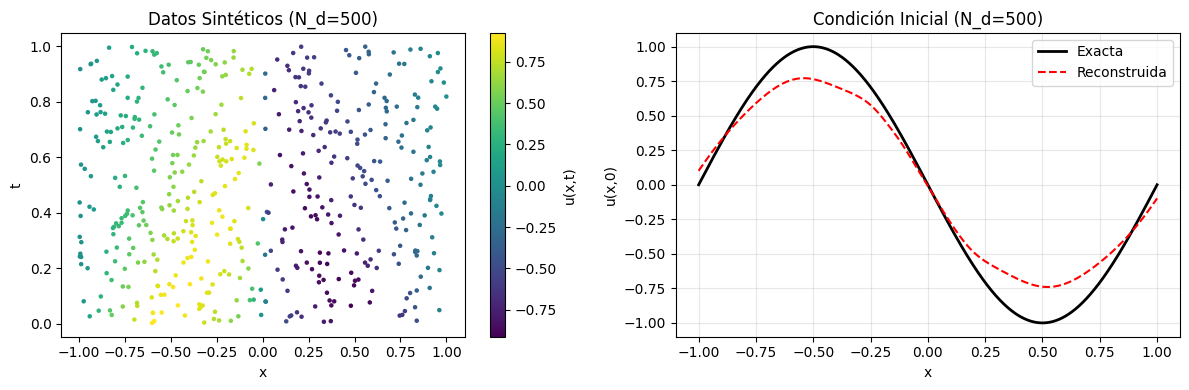


PROCESANDO DATASET CON N_d = 1000

Entrenando modelo inverso para N_d=1000...
[INV] Epoch  1000 | Loss: 7.929e-02
[INV] Epoch  2000 | Loss: 5.028e-02
[INV] Epoch  3000 | Loss: 3.943e-02
[INV] Epoch  4000 | Loss: 3.792e-02
[INV] Epoch  5000 | Loss: 3.698e-02
[INV] Epoch  6000 | Loss: 3.655e-02


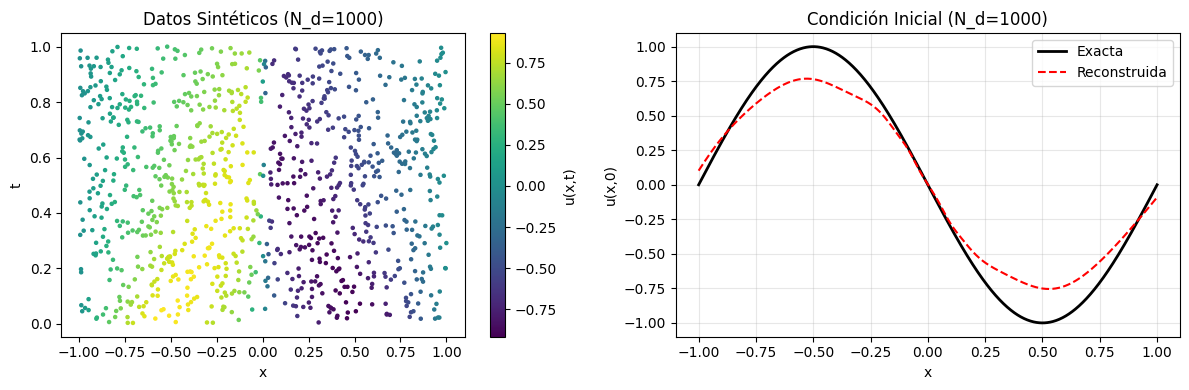


PROCESANDO DATASET CON N_d = 1500

Entrenando modelo inverso para N_d=1500...
[INV] Epoch  1000 | Loss: 6.644e-02
[INV] Epoch  2000 | Loss: 4.683e-02
[INV] Epoch  3000 | Loss: 3.952e-02
[INV] Epoch  4000 | Loss: 3.632e-02
[INV] Epoch  5000 | Loss: 3.541e-02
[INV] Epoch  6000 | Loss: 3.500e-02


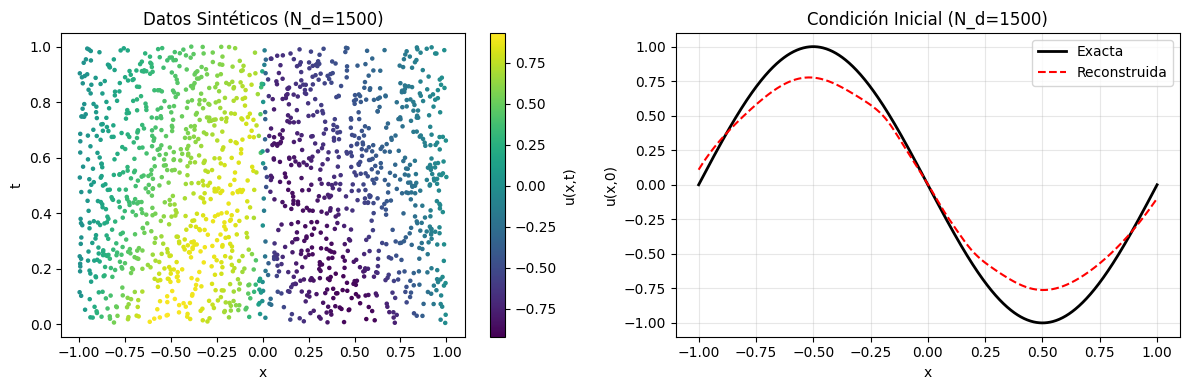


Resultados de la reconstrucción inversa:
    N_d       Error
0   500  2.2790e-01
1  1000  2.2399e-01
2  1500  2.1646e-01


In [ ]:
# ============================================================
# BLOQUE 1: PROBLEMA DIRECTO (PINN) -> GENERACIÓN DE DATOS Y PLOTS
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configuración inicial
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parámetros de la ecuación de Burgers
nu = 0.01
x_min, x_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0

# Definición de la red neuronal
class BurgersPINN(nn.Module):
    def __init__(self):
        super(BurgersPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
    def forward(self, x, t):
        return self.net(torch.cat((x, t), dim=1))

# Función de condición inicial exacta
def u0_star(x):
    return -torch.sin(np.pi * x)

# Generación de puntos de entrenamiento
N_f = 15000  # Puntos de colocación
N_b = 400    # Puntos de frontera
N_i = 2000   # Puntos iniciales

x_f = (x_min + (x_max - x_min) * torch.rand(N_f, 1, device=device)).requires_grad_(True)
t_f = (t_min + (t_max - t_min) * torch.rand(N_f, 1, device=device)).requires_grad_(True)
t_b = torch.linspace(t_min, t_max, N_b, device=device).reshape(-1, 1)
x_bL = -torch.ones_like(t_b, device=device)
x_bR =  torch.ones_like(t_b, device=device)
u_bL = torch.zeros_like(t_b, device=device)
u_bR = torch.zeros_like(t_b, device=device)
x_i = torch.linspace(x_min, x_max, N_i, device=device).reshape(-1, 1)
t_i = torch.zeros_like(x_i, device=device)
u_i = u0_star(x_i)

# Funciones de derivadas y residual de la EDP
def grads(u, x):
    return torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]

def pde_residual(model, x, t, nu):
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    return u_t + u * u_x - nu * u_xx

# Función de pérdida para problema directo
w_phys, w_bc, w_ic = 0.3, 0.3, 0.4
def loss_forward(model):
    R = pde_residual(model, x_f, t_f, nu)
    L_phys = torch.mean(R**2)
    uL = model(x_bL, t_b)
    uR = model(x_bR, t_b)
    L_bc = torch.mean((uL - u_bL)**2) + torch.mean((uR - u_bR)**2)
    u_init = model(x_i, t_i)
    L_ic = torch.mean((u_init - u_i)**2)
    return w_phys*L_phys + w_bc*L_bc + w_ic*L_ic, {'phys':L_phys.item(), 'bc':L_bc.item(), 'ic':L_ic.item()}

# Entrenamiento del modelo directo
model_fwd = BurgersPINN().to(device)
optimizer = optim.Adam(model_fwd.parameters(), lr=1e-3)
epochs_fwd = 5000

print("Entrenando modelo directo...")
for epoch in range(1, epochs_fwd+1):
    optimizer.zero_grad()
    L, parts = loss_forward(model_fwd)
    L.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"[FWD] Epoch {epoch:5d} | Loss: {L.item():.3e}")

# Generar malla para visualización
nx, nt = 200, 200
xg = torch.linspace(x_min, x_max, nx, device=device)
tg = torch.linspace(t_min, t_max, nt, device=device)
Xg, Tg = torch.meshgrid(xg, tg, indexing='xy')
Xg_flat = Xg.reshape(-1, 1)
Tg_flat = Tg.reshape(-1, 1)
with torch.no_grad():
    Ug = model_fwd(Xg_flat, Tg_flat).reshape(nt, nx).cpu().numpy()

# Visualización de la solución directa
plt.figure(figsize=(8, 6))
plt.imshow(Ug, extent=[x_min, x_max, t_min, t_max], origin='lower', aspect='auto')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solución Directa u(x,t) - PINN')
plt.tight_layout()
plt.show()

# ============================================================
# BLOQUE 2: PROBLEMA INVERSO CON MÚLTIPLES TAMAÑOS DE DATASET
# ============================================================

# Lista de tamaños de dataset a evaluar
N_d_list = [500, 1000, 1500]
results = []

for N_d in N_d_list:
    print(f"\n{'='*50}")
    print(f"PROCESANDO DATASET CON N_d = {N_d}")
    print(f"{'='*50}")

    # Generar datos sintéticos
    torch.manual_seed(42)
    np.random.seed(42)
    x_d = (x_min + (x_max - x_min) * torch.rand(N_d, 1, device=device))
    t_d = (t_min + (t_max - t_min) * torch.rand(N_d, 1, device=device))
    with torch.no_grad():
        u_d = model_fwd(x_d, t_d)

    # Visualización de los datos generados
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.scatter(x_d.cpu().numpy(), t_d.cpu().numpy(), c=u_d.cpu().numpy(), s=5, cmap='viridis')
    plt.colorbar(label='u(x,t)')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f'Datos Sintéticos (N_d={N_d})')

    # Modelo para problema inverso
    model_inv = BurgersPINN().to(device)

    # Puntos para términos físicos y de regularización
    N_f_inv = 15000
    x_f_inv = (x_min + (x_max - x_min) * torch.rand(N_f_inv, 1, device=device)).requires_grad_(True)
    t_f_inv = (t_min + (t_max - t_min) * torch.rand(N_f_inv, 1, device=device)).requires_grad_(True)
    N_b_inv = 400
    t_b_inv = torch.linspace(t_min, t_max, N_b_inv, device=device).reshape(-1, 1)
    x_bL_inv = -torch.ones_like(t_b_inv, device=device)
    x_bR_inv = torch.ones_like(t_b_inv, device=device)
    u_bL_inv = torch.zeros_like(t_b_inv, device=device)
    u_bR_inv = torch.zeros_like(t_b_inv, device=device)
    N0 = 1024
    x0_reg = torch.linspace(x_min, x_max, N0, device=device).reshape(-1,1).requires_grad_(True)
    t0_reg = torch.zeros_like(x0_reg, device=device)

    # Función de pérdida para problema inverso
    lambda_d, lambda_f, lambda_b, lambda_reg = 1, 1, 1, 1e-2
    def loss_inverse(model):
        u_pred = model(x_d, t_d)
        L_data = torch.mean((u_pred - u_d)**2)
        R = pde_residual(model, x_f_inv, t_f_inv, nu)
        L_phys = torch.mean(R**2)
        uL = model(x_bL_inv, t_b_inv)
        uR = model(x_bR_inv, t_b_inv)
        L_bc = torch.mean((uL - u_bL_inv)**2) + torch.mean((uR - u_bR_inv)**2)
        u0 = model(x0_reg, t0_reg)
        u0_x = grads(u0, x0_reg)
        L_reg = torch.mean(u0_x**2)
        L_total = lambda_d*L_data + lambda_f*L_phys + lambda_b*L_bc + lambda_reg*L_reg
        return L_total, {'data':L_data.item(), 'phys':L_phys.item(), 'bc':L_bc.item(), 'reg':L_reg.item()}

    # Entrenamiento del modelo inverso
    optimizer_inv = optim.Adam(model_inv.parameters(), lr=1e-3)
    epochs_inv = 6000

    print(f"\nEntrenando modelo inverso para N_d={N_d}...")
    for epoch in range(1, epochs_inv+1):
        optimizer_inv.zero_grad()
        L, parts = loss_inverse(model_inv)
        L.backward()
        optimizer_inv.step()
        if epoch % 1000 == 0:
            print(f"[INV] Epoch {epoch:5d} | Loss: {L.item():.3e}")

    # Evaluar condición inicial reconstruida
    x_eval = torch.linspace(x_min, x_max, 1000, device=device).reshape(-1,1)
    t0_eval = torch.zeros_like(x_eval)
    with torch.no_grad():
        u0_rec = model_inv(x_eval, t0_eval).cpu().numpy()

    u0_exact = -np.sin(np.pi * x_eval.cpu().numpy())

    # Calcular error relativo L2
    dx = (x_max - x_min) / 999
    error_l2 = np.sqrt(np.sum((u0_rec - u0_exact)**2) * dx)
    norm_exact = np.sqrt(np.sum(u0_exact**2) * dx)
    rel_error = error_l2 / norm_exact

    # Almacenar resultados
    results.append({
        'N_d': N_d,
        'Error': rel_error
    })

    # Graficar comparación de condición inicial
    plt.subplot(122)
    plt.plot(x_eval.cpu(), u0_exact, 'k-', linewidth=2, label='Exacta')
    plt.plot(x_eval.cpu(), u0_rec, 'r--', linewidth=1.5, label='Reconstruida')
    plt.xlabel('x')
    plt.ylabel('u(x,0)')
    plt.title(f'Condición Inicial (N_d={N_d})')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'cond_inicial_N_d_{N_d}.pdf')
    plt.show()

    # Limpieza de memoria
    del model_inv, optimizer_inv, x_d, t_d, u_d
    torch.cuda.empty_cache()

# Mostrar tabla de resultados finales
print("\nResultados de la reconstrucción inversa:")
df_results = pd.DataFrame(results)
df_results['Error'] = df_results['Error'].apply(lambda x: f"{x:.4e}")
print(df_results[['N_d', 'Error']])